In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as opt
torch.set_printoptions(linewidth=120)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from dense import densenet121
print(torch.__version__)

1.8.1+cu111


(600, 600, 3)

array([142.05081389, 142.05081389, 142.05081389])

id  Negative for Pneumonia  Typical Appearance  \
0  00086460a852_study                       0                   1   
1  000c9c05fd14_study                       0                   0   
2  00292f8c37bd_study                       1                   0   
3  005057b3f880_study                       1                   0   
4  0051d9b12e72_study                       0                   0   

   Indeterminate Appearance  Atypical Appearance  
0                         0                    0  
1                         0                    1  
2                         0                    0  
3                         0                    0  
4                         0                    1

Index(['id', 'Negative for Pneumonia', 'Typical Appearance',
       'Indeterminate Appearance', 'Atypical Appearance'],
      dtype='object')

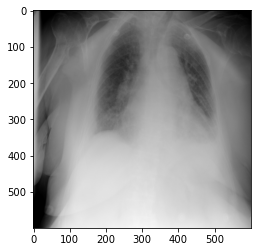

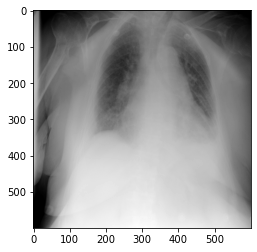

In [11]:
study_label = pd.read_csv('../archive/train_study_level.csv')
study_example = cv2.imread('../archive/study/00086460a852_study.png')
display(study_example.shape)
plt.imshow(study_example, cmap='gray')
display(np.mean(study_example, axis=(0,1)))
study_example = study_example[:, :, 0]
plt.figure()
plt.imshow(study_example, cmap='gray')
display(study_label.head())
display(study_label.columns)

In [12]:
paths = []
ids = study_label.id
labels = study_label.iloc[:, 1:].to_numpy()
for i in range(len(ids)):
    paths.append('../archive/study/{x}.png'.format(x = ids[i]))
paths = np.array(paths)
display(paths.shape, labels.shape)

(6054,)

(6054, 4)

In [5]:
class DenseNet121(nn.Module):
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = densenet121(pretrained=False, **{'drop_rate' : 0.3})
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [6]:
model = DenseNet121(4)
print(model)

DenseNet121(
  (densenet121): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [4]:
class classification(nn.Module):
    def __init__(self, paths, labels, aug=False):
        self.paths = paths
        self.labels = labels
        self.aug = aug
        self.example = []
    
    def __getitem__(self, idx):
            path = self.paths[idx]
            img = cv2.imread(path)[:, :, 0]
            img = (img - np.mean(img))/np.std(img)
            #img = img/np.mean(img)
            img = cv2.resize(img, (512, 512))
            x = torch.from_numpy(np.array(img)).view((1, 512, 512))
            x = x.float()
            y = np.argmax(self.labels[idx])
            y = torch.tensor(y)
            return x, y
        
    def __len__(self):
        return len(self.paths)
    
    def get(self):
        return self.example

In [16]:
dataset = classification(paths[:500], labels[:500])
print(len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset, [400, 100])

500


In [17]:
class Trainer():
    def __init__(self,model,train_set,test_set,opts):
        self.model = model  # neural net
        # device agnostic code snippet
        self.device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.model.to(self.device)
        
        self.epochs = opts['epochs']
        self.optimizer = torch.optim.Adam(model.parameters(), opts['lr'], weight_decay=1e-5, amsgrad=True) # optimizer method for gradient descent
        self.criterion = torch.nn.CrossEntropyLoss()                      # loss function
        self.train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                                        batch_size=opts['batch_size'],
                                                        shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                                       batch_size=opts['batch_size'],
                                                       shuffle=False)
        self.tb = SummaryWriter()
        self.best_loss = 1e10
        
    def train(self):
        for epoch in range(self.epochs):
            self.model.train() #put model in training mode
            self.tr_loss = []
            for i, (data,labels) in tqdm(enumerate(self.train_loader),
                                                   total = len(self.train_loader)):
                data, labels = data.to(self.device),labels.to(self.device)
                self.optimizer.zero_grad()  
                outputs = self.model(data)   
                loss = self.criterion(outputs, labels) 
                loss.backward()                        
                self.optimizer.step()                  
                self.tr_loss.append(loss.item())     
            self.tb.add_scalar("Train Loss", np.mean(self.tr_loss), epoch)
            self.test(epoch) # run through the validation set
        self.tb.close()
            
    def test(self,epoch):
            
            self.model.eval()    # puts model in eval mode - not necessary for this demo but good to know
            self.test_loss = []
            self.test_accuracy = []
            
            for i, (data, labels) in enumerate(self.test_loader):
                
                data, labels = data.to(self.device),labels.to(self.device)
                
                with torch.no_grad():
                    outputs = self.model(data)
                
                _, predicted = torch.max(outputs.data, 1)
                loss = self.criterion(outputs, labels)
                self.test_loss.append(loss.item())
                
                self.test_accuracy.append((predicted == labels).sum().item() / predicted.size(0))
            
            print('epoch: {}, train loss: {}, test loss: {}, test accuracy: {}'.format( 
                  epoch+1, np.mean(self.tr_loss), np.mean(self.test_loss), np.mean(self.test_accuracy)))
            self.tb.add_scalar("Val Acc", np.mean(self.test_accuracy), epoch)
            self.tb.add_scalar("Val Loss", np.mean(self.test_loss), epoch)
            if np.mean(self.test_loss) < self.best_loss:
                self.best_loss = np.mean(self.test_loss)
                torch.save(self.model.state_dict(), './model_weights/best.pt')

In [18]:
opts = {
    'lr': 1e-4,
    'epochs': 60,
    'batch_size': 32
}
train = Trainer(model, train_set, val_set, opts)
train.train()

cuda:2


RuntimeError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 2; 23.70 GiB total capacity; 21.73 GiB already allocated; 242.94 MiB free; 21.77 GiB reserved in total by PyTorch)